<a href="https://colab.research.google.com/github/44REAM/CEB-image_processing/blob/main/Diffusion_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diffusion tensor imaging (DTI)
---


# Resources

- MRI image acquisition: https://www.youtube.com/playlist?list=PLIfBbrWfKu6-XPvqWM6aZhlKKOuRLIJWG
- MRI question: https://mriquestions.com/index.html
- DWI: http://xrayphysics.com/dwi.html
- DWI: https://www.youtube.com/watch?v=J_aamnpRJE8&t=408s
- Tensor: https://www.youtube.com/watch?v=f5liqUk0ZTw&t=126s
- Tensor image: https://www.youtube.com/watch?v=YxXyN2ifK8A
- Review practical use of DWI in brain image: https://www.mdpi.com/2072-6694/15/3/618
- DIPY workshop: https://www.youtube.com/playlist?list=PLRZ9VSqV-6srrTAcDh4JYwrlef2Zpjucw

In [1]:
!git clone https://github.com/44REAM/CEB-image_processing.git
%cd /content/CEB-image_processing
!pip install dipy
!pip install fury

Cloning into 'CEB-image_processing'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 413 (delta 12), reused 6 (delta 6), pack-reused 393
Receiving objects: 100% (413/413), 73.21 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (235/235), done.
/content/CEB-image_processing
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.5 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.15.6-py3-none-any.whl size=26316 sha256=a6517ce5d2c771cbaacce6acc88530895e01f9b24f2474db0b9c8c51a96adbcf
  Stored in directory: /root/.cache/pip/wheels/bb/41/60/e52cef7b945603a2df661df2ebfc4f79d4c20395809b8e081

# DTI reconstruction

In [34]:
import numpy as np

from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

import dipy.reconst.dti as dti
import matplotlib.pyplot as plt

## Data

- DWI image: 4D image (x, y, z, sequence). (You can see the 4D image as sequences of 3D image)
- b value: factor that reflects the strength and timing of the gradients used to generate diffusion-weighted images. https://www.youtube.com/watch?v=1CPPcJH9JWs
- b vector: Direction of the gradient https://www.youtube.com/watch?v=26uuhmhAHIA


In [35]:

# get name of the data
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')

data, affine = load_nifti(hardi_fname)

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


In [36]:
print(data.shape)
print(bvals.shape)
print(bvecs.shape)

(81, 106, 76, 160)
(160,)
(160, 3)


In [37]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(0, 9),
                             numpass=1, dilate=5)

print('data.shape (%d, %d, %d, %d)' % data.shape)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

data.shape (81, 106, 76, 160)
maskdata.shape (81, 106, 76, 160)


## Apparent Diffusion Coefficient

The simplest assumption on the diffusion is the water molecule can diffuse equally in all direction (***Isotropic diffusion***). We can write the image intensity after apply the diffusion gradient as below.

$$I = I_0 * e^{-b * D_{ADC}}$$

where $I_0$ is intensity of the image without magnetic gradient. $b$ is bvalue and $D_{ADC}$ is the diffusion coeffient. By fitting the equation we can get image of $D_{ADC}$ called, apparent diffusion coefficient (ADC) map.

The ADC map is a pure display of consolidated ADC values. Tissues with restrict diffusion (low ADC values) (stroke, abscesses, etc.) appear dark, while materials like CSF (no restriction) with high ADC values appear bright.

cerebral infarction: https://mriquestions.com/lightdark-reversal.html

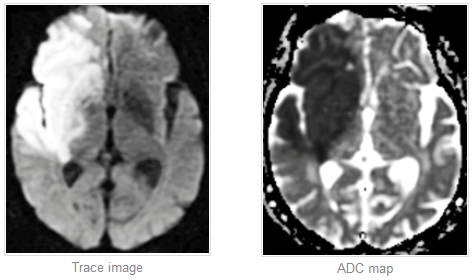

## Diffusion Tensor image

Actually the water not diffuse equally in all direction, for example, diffuse along in direction of axon (this is because myelin sheaths encircle the neurons and prevent water diffusion across the sheath). Diffusion that is directionally dependent is referred to as ***anisotropic diffusion***.

$$I = I_0 * e^{-b * g^TD_{DTI}  g }$$

Where $b$ is the b value, $g$ is b vector and $D_{DTI} $ is diffusion tensor.

In [38]:
gtab = gradient_table(bvals, bvecs)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

In [6]:
gtab.gradients.shape

(160, 3)

In [7]:
bvals

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000.,

In [8]:
np.linalg.norm(gtab.gradients, axis= 1)

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        , 1999.99956758, 2000.00711661,
       2000.00397153, 1999.99226009, 1999.99475849, 2000.0015034 ,
       1999.9979929 , 2000.00657939, 2000.0098589 , 2000.0016723 ,
       2000.00421891, 2000.0039005 , 2000.00433264, 2000.0039437 ,
       1999.99325609, 1999.9970326 , 2000.00218898, 1999.99284019,
       2000.00490082, 1999.9962505 , 1999.99511352, 1999.99412221,
       1999.9974203 , 1999.9963131 , 2000.01078987, 1999.99448189,
       2000.00622209, 2000.0026481 , 2000.0022834 , 2000.0042899 ,
       1999.99147738, 1999.98455774, 1999.9984966 , 1999.9999028 ,
       1999.98492004, 2000.00074666, 1999.99524347, 2000.01088487,
       1999.99524099, 1999.9908938 , 1999.9989691 , 1999.99343635,
       1999.99308729, 1999.9957907 , 2000.0037405 , 1999.9968129 ,
       2000.0038929 , 1999.99041631, 1999.9972966 , 1999.98923

In [9]:
np.linalg.norm(bvecs, axis = 1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.99999978, 1.00000356, 1.00000199, 0.99999613, 0.99999738,
       1.00000075, 0.999999  , 1.00000329, 1.00000493, 1.00000084,
       1.00000211, 1.00000195, 1.00000217, 1.00000197, 0.99999663,
       0.99999852, 1.00000109, 0.99999642, 1.00000245, 0.99999813,
       0.99999756, 0.99999706, 0.99999871, 0.99999816, 1.00000539,
       0.99999724, 1.00000311, 1.00000132, 1.00000114, 1.00000214,
       0.99999574, 0.99999228, 0.99999925, 0.99999995, 0.99999246,
       1.00000037, 0.99999762, 1.00000544, 0.99999762, 0.99999545,
       0.99999948, 0.99999672, 0.99999654, 0.9999979 , 1.00000187,
       0.99999841, 1.00000195, 0.99999521, 0.99999865, 0.99999462,
       1.00000282, 1.00000199, 1.00000158, 1.00000058, 0.99999968,
       1.00000248, 0.99999944, 0.99999793, 0.99999888, 1.00000305,
       1.0000016 , 0.99999992, 1.00000396, 1.00000248, 1.00000

# What is tensor

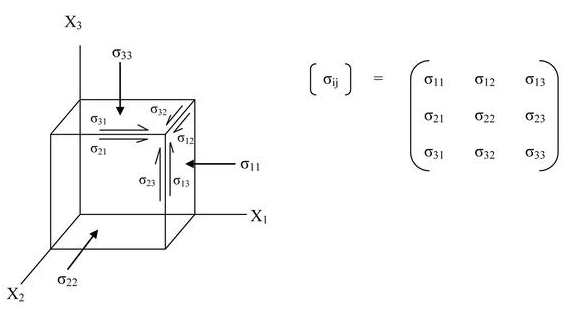

### What is diffusion tensor?

https://www.youtube.com/watch?v=f5liqUk0ZTw&t=126s

In this case you can view diffusion tensor as a model parameter that described transformation of the image in each voxel (How the water in each voxel move).

$$
D_{DTI} =
\begin{bmatrix}
D_{xx} & D_{xy} & D_{xz} \\
D_{yx} & D_{yy} & D_{yz} \\
D_{zx} & D_{zy} & D_{zz}
\end{bmatrix}
$$

#### Diffusion Tensor are symmetric

Diffusion Tensor are symmetric since x→y ($D_{xy}$) and y→x ($D_{yx}$) diffusivities should be the same.

In [10]:
# diffusion tensor per voxel
print(f"shape of output {tenfit.quadratic_form.shape} \n")

# diffusion tensor at voxel (0,0,0)
x = 0; y=0; z=0
print(f"diffusion tensor at voxel ({x},{y},{z})")
print(tenfit.quadratic_form[x,y,z,:,:])

shape of output (81, 106, 76, 3, 3) 

diffusion tensor at voxel (0,0,0)
[[ 5.00006825e-10  0.00000000e+00 -2.58493941e-26]
 [-2.58493941e-26  5.00006825e-10 -2.58493941e-26]
 [ 5.16987883e-26 -2.58493941e-26  5.00006825e-10]]


For each diffusion tensor (view as transformation matrix per voxel), we can calculate the property of transformation such as eigenvalue and eigenvector. The eigenvector here describe the direction of diffusion and eigenvalue that corresponse to eigenvector describe strength of diffusion. Common image that extracted from DTI are fractional anisotropy (FA) and Mean diffusivity (MD) (or ADC).





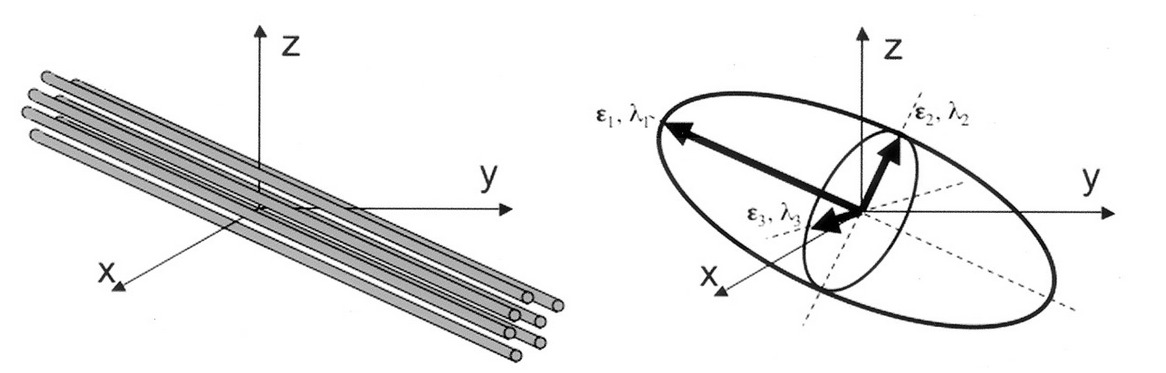

The $D_{ADC}$ can be calculate by using average of the diffusion in three direction $x, y, z$ $(D_{xx}, D_{yy}, D_{zz})$

$$D_{ADC}= MD = \frac{D_{xx}+ D_{yy}+ D_{zz}}{3} = \frac{λ_1+λ_2+λ_3}{3}$$

In otherword, $D_{ADC}$ is the average of an eigenvalue.

$$FA = \sqrt{\frac{3}{2}} \frac
{\sqrt{(λ_1-\hat{\lambda})^2 + (λ_2-\hat{\lambda})^2 + (λ_3-\hat{\lambda})^2}}
{\sqrt{(λ_1^2+λ_2^2+λ_3^2)}}$$

Where $\hat{\lambda} = MD$

In [11]:
# eigenvectors
print(tenfit.evecs.shape)

# eigenvalues
print(tenfit.evals.shape)

(81, 106, 76, 3, 3)
(81, 106, 76, 3)


In [12]:
# MD = dti.mean_diffusivity(tenfit.evals)
MD = tenfit.md

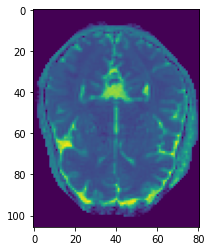

In [13]:
plt.imshow(MD[:,:,30].T)

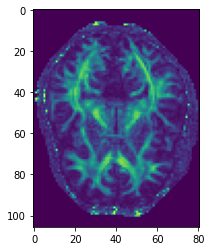

In [14]:
from dipy.reconst.dti import fractional_anisotropy
FA = tenfit.fa
FA = np.clip(FA, 0, 1)
plt.imshow(FA[:,:,30].T)

#### FA with color

- red indicates that diffusion is higher on right-left directions
- green indicates that diffusion is higher on anterior-posterior directions
- blue indicates that diffusion is higher on inferior-superior directions


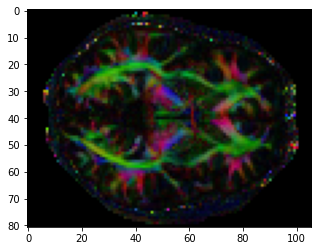

In [15]:
from dipy.reconst.dti import color_fa
colored_FA = color_fa(FA, tenfit.evecs)
plt.imshow(colored_FA[:,:,30])

# DWI application

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2766891/

# Deterministic tractography using DTI



## Streamline tractography

1. image of orientation: tensors, Fiber Orientation Distribution Functions
2. direction selection strategy: deterministic, probabilistic
3. stopping criterion: eg. stop if outside the mask, angle between two vector large, etc.
4. seeding mask
5. step size

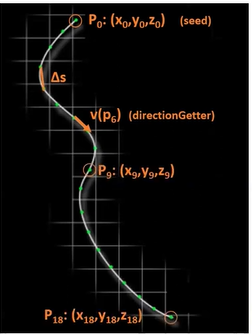

In [16]:


from dipy.io.image import load_nifti_data

# white_matter = (labels == 1) | (labels == 2)
label_fname = get_fnames('stanford_labels')
labels = load_nifti_data(label_fname)
white_matter = (labels == 1) | (labels == 2)



In [23]:
# labels all point of DWI
labels.shape

(81, 106, 76)

In [17]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86,
       87, 88], dtype=uint8)

### find peak

In [18]:
from dipy.direction import peaks_from_model
from dipy.data import default_sphere

tenmodel = dti.TensorModel(gtab)
# find direction which have large diffusion.
dti_peaks = peaks_from_model(
    tenmodel, 
    maskdata,
    default_sphere,
    relative_peak_threshold=.8,
    # if two peaks are closer than min_separation_angle, larger peak return (in degrees)
    min_separation_angle=45,
    # maximum number of peaks to return
    npeaks = 1,
    # mask to exclude some voxels
    mask=white_matter)



In [19]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

# Criteria for stopping the tract
stopping_criterion = ThresholdStoppingCriterion(FA, .2)

In [20]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking import utils

# start location of tract
seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

streamlines_generator = LocalTracking(dti_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)

In [21]:

from dipy.tracking.streamline import Streamlines

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)


In [22]:


from dipy.viz import colormap, window, actor, has_fury

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='dti_tractogram.png', size=(800, 800))
    window.show(scene)

